In [ ]:
!pip install langchain_groq
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 42.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.0 which is incompatible.


In [ ]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from google.colab import userdata





*Tools*




In [ ]:
load_dotenv()

document_content = ""

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


@tool
def update(content: str) -> str:
    """Updates the document with the provided content."""
    global document_content
    document_content = content
    return f"Document has been updated successfully! The current content is:\n{document_content}"


@tool
def save(filename: str) -> str:
    """Save the current document to a text file and finish the process.

    Args:
        filename: Name for the text file.
    """

    global document_content

    if not filename.endswith('.txt'):
        filename = f"{filename}.txt"


    try:
        with open(filename, 'w') as file:
            file.write(document_content)
        print(f"\n💾 Document has been saved to: {filename}")
        return f"Document has been saved successfully to '{filename}'."

    except Exception as e:
        return f"Error saving document: {str(e)}"

In [ ]:


tools = [update, save]


groq_api_key = userdata.get("groq_api")


llm = ChatGroq(
    model="llama-3.1-8b-instant",
    groq_api_key=groq_api_key,
)

def our_agent(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content=f"""
    You are Drafter, a helpful writing assistant. You are going to help the user update and modify documents.

    - If the user wants to update or modify content, use the 'update' tool with the complete updated content.
    - If the user wants to save and finish, you need to use the 'save' tool.
    - Make sure to always show the current document state after modifications.

    The current document content is:{document_content}
    """)

    if not state["messages"]:
        user_input = "I'm ready to help you update a document. What would you like to create?"
        user_message = HumanMessage(content=user_input)

    else:
        user_input = input("\nWhat would you like to do with the document? ")
        print(f"\n👤 USER: {user_input}")
        user_message = HumanMessage(content=user_input)

    all_messages = [system_prompt] + list(state["messages"]) + [user_message]

    response = llm.invoke(all_messages)

    print(f"\n🤖 AI: {response.content}")
    if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

    return {"messages": list(state["messages"]) + [user_message, response]}


def should_continue(state: AgentState) -> str:
    """Determine if we should continue or end the conversation."""

    messages = state["messages"]

    if not messages:
        return "continue"

    # This looks for the most recent tool message....
    for message in reversed(messages):
        # ... and checks if this is a ToolMessage resulting from save
        if (isinstance(message, ToolMessage) and
            "saved" in message.content.lower() and
            "document" in message.content.lower()):
            return "end" # goes to the end edge which leads to the endpoint

    return "continue"

def print_messages(messages):
    """Function I made to print the messages in a more readable format"""
    if not messages:
        return

    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\n🛠️ TOOL RESULT: {message.content}")

In [ ]:
graph = StateGraph(AgentState)

graph.add_node("agent", our_agent)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("agent")

graph.add_edge("agent", "tools")


graph.add_conditional_edges(
    "tools",
    should_continue,
    {
        "continue": "agent",
        "end": END,
    },
)

app = graph.compile()

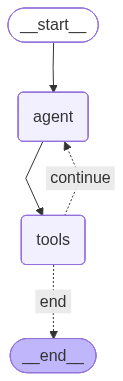

In [ ]:
from IPython.display import Image ,display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:




def run_document_agent():
    print("\n ===== DRAFTER =====")

    state = {"messages": []}

    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])

    print("\n ===== DRAFTER FINISHED =====")

if __name__ == "__main__":
    run_document_agent()



 ===== DRAFTER =====

🤖 AI: I'd like to create a company policy document. Here's a basic outline to get us started:

**Company Policy Document**

**Introduction**

Our company values our employees and strives to create a safe, inclusive, and productive work environment. This policy document outlines our expectations, guidelines, and procedures to ensure a positive and successful work experience.

**Current Document Content:**
```markdown
# Company Policy Document

## Introduction
Our company values our employees and strives to create a safe, inclusive, and productive work environment. This policy document outlines our expectations, guidelines, and procedures to ensure a positive and successful work experience.

## Code of Conduct
All employees are expected to adhere to the following code of conduct:

- Treat all colleagues with respect and dignity
- Maintain confidentiality and protect company secrets
- Refrain from any form of harassment or bullying

## Reporting Incidents
If you wit